# Figure - defocus series

In [1]:
import os
work_dir = "H:/workspace/ptyrad_paper"
os.chdir(work_dir)
print("Current working dir: ", os.getcwd())

Current working dir:  H:\workspace\ptyrad_paper


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ptyrad.load import load_ptyrad
from ptyrad.utils.image_proc import center_crop

In [3]:
from ptyrad.utils import (
    get_default_probe_simu_params,
    make_mixed_probe,
    make_stem_probe,
)

In [4]:
def mixed_probe_to_total_amp(modes):
    
    return np.sum(np.abs(modes)**2, 0)**0.5

In [5]:
defoci = [-200, -100, -50, 0, 50, 100, 200]

ptyrad_objects = []
ptyrad_recon_probes = []
ptyrad_init_probes = []

for i, df in enumerate(defoci):
    path_ptyrad   = f"03_output/tBL_WSe2/20250610_ptyrad_df_series/full_N16384_dp128_flipT100_random16_p12_1obj_6slice_dz2_Adam_plr1e-4_oalr5e-4_oplr5e-4_slr5e-4_orblur0.5_ozblur1_oathr0.98_oposc_sng1.0_spr0.1_ca24.9_df{df}_aff1_0_-3_0/model_iter0200.hdf5"
    ckpt_ptyrad = load_ptyrad(path_ptyrad)
    
    object_ptyrad = center_crop(ckpt_ptyrad['optimizable_tensors']['objp'].squeeze().sum(0), 384, 384)
    
    probe_ptyrad = ckpt_ptyrad['optimizable_tensors']['probe']
    init_params = ckpt_ptyrad['params']['init_params']
    pixel_size = ckpt_ptyrad['model_attributes']['dx']
    init_params['probe_dx'] = pixel_size
    simu_params = get_default_probe_simu_params(init_params)
    probe_init_single = make_stem_probe(simu_params)[None, ...]
    probe_init_mixed = make_mixed_probe(probe_init_single[0], simu_params['pmodes'], simu_params['pmode_init_pows'])
    
    ptyrad_objects.append(object_ptyrad)
    ptyrad_recon_probes.append(mixed_probe_to_total_amp(probe_ptyrad))
    ptyrad_init_probes.append(mixed_probe_to_total_amp(probe_init_mixed))

Success! Loaded .hdf5 file as a dict from path = '03_output/tBL_WSe2/20250610_ptyrad_df_series/full_N16384_dp128_flipT100_random16_p12_1obj_6slice_dz2_Adam_plr1e-4_oalr5e-4_oplr5e-4_slr5e-4_orblur0.5_ozblur1_oathr0.98_oposc_sng1.0_spr0.1_ca24.9_df-200_aff1_0_-3_0/model_iter0200.hdf5'
Start simulating STEM probe
  kv          = 80.0 kV
  wavelength  = 0.0418 Ang
  conv_angle  = 24.9 mrad
  Npix        = 128 px
  dk          = 0.0523 Ang^-1
  kMax        = 3.3467 Ang^-1
  alpha_max   = 139.7447 mrad
  dx          = 0.1494 Ang, Nyquist-limited dmin = 2*dx = 0.2988 Ang
  Rayleigh-limited resolution  = 1.0229 Ang (0.61*lambda/alpha for focused probe )
  Real space probe extent = 19.1232 Ang
Start making mixed-state STEM probe with 12 incoherent probe modes
Relative power of probe modes = [0.78 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]
Success! Loaded .hdf5 file as a dict from path = '03_output/tBL_WSe2/20250610_ptyrad_df_series/full_N16384_dp128_flipT100_random16_p12_1obj_6sli

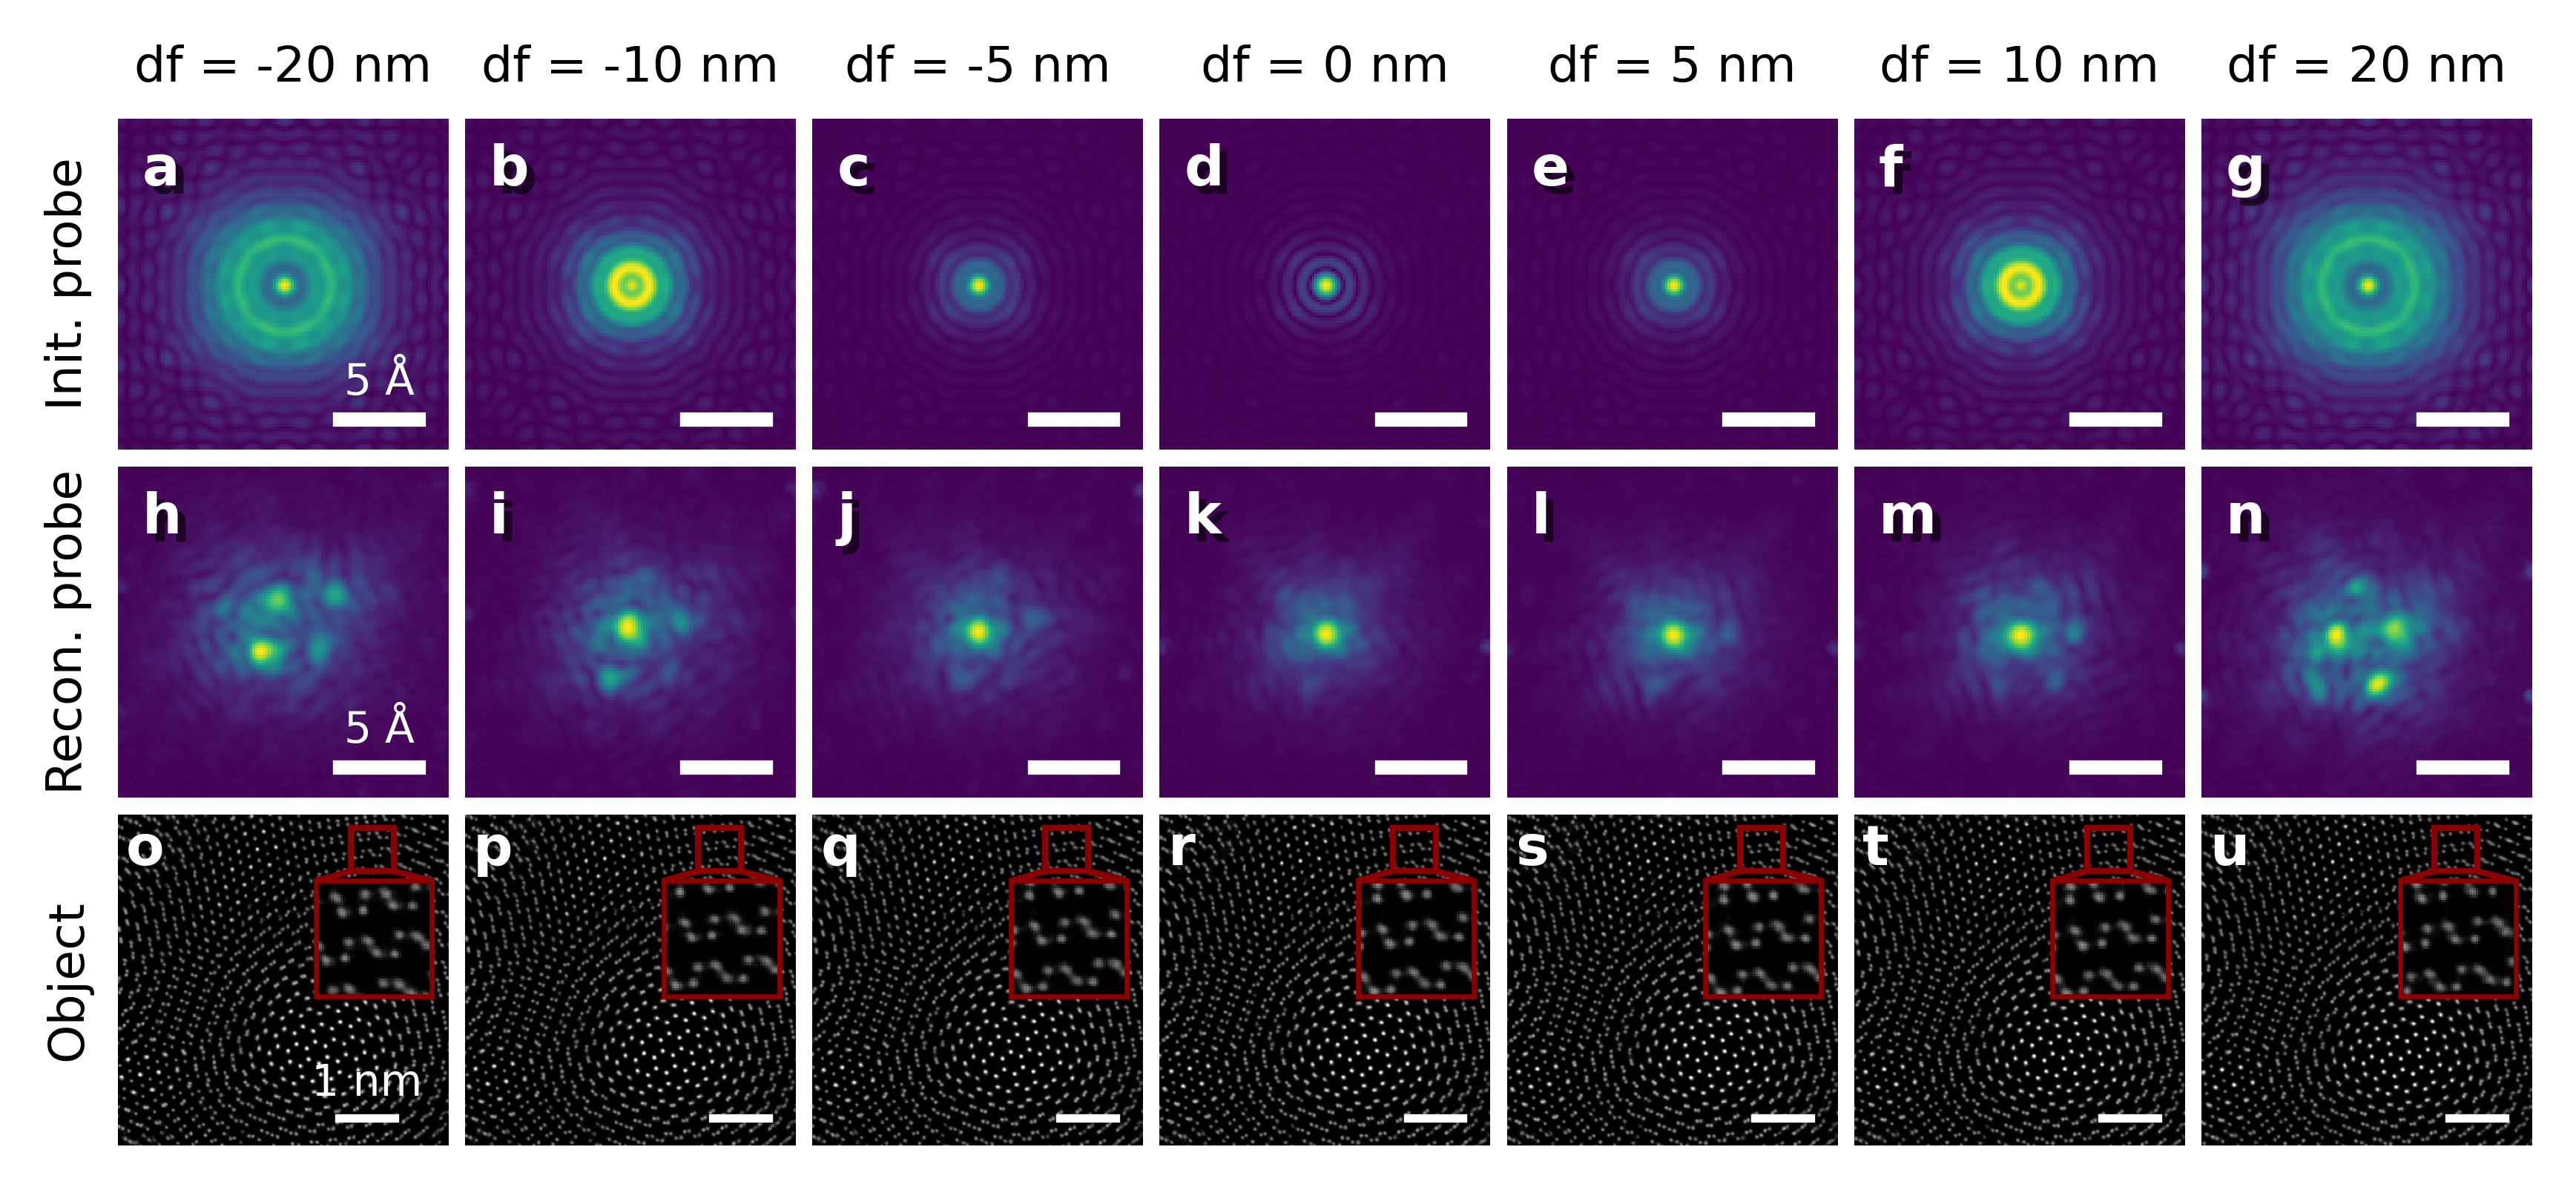

In [6]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import string

# Figure configuration
figsize = (7, 3.3)
row_labels = ['Init. probe', 'Recon. probe', 'Object']
col_labels = [f'df = {df/10:.2g} nm' for df in defoci]
num_rows = len(row_labels)
num_cols = len(col_labels)
total_panels = num_rows * num_cols
fontsize_row_label = 8
fontsize_cols_label=  8
fontsize_panel_label = 9
probe_cmap = 'viridis'
hspace = -0.2

# Panel labels
if total_panels > len(string.ascii_lowercase):
    raise ValueError("Too many panels for single-letter labels. Consider using double letters.")
panel_labels = np.array(list(string.ascii_lowercase[:total_panels])).reshape(num_rows, num_cols)
shadow_offset = (3, 3)

# Zoom-in region
zoom_region = (270, 320, 65, 15)  

# Define figure and GridSpec layout
fig = plt.figure(figsize=figsize, dpi=600)
gs = gridspec.GridSpec(num_rows, num_cols, wspace=0.05, hspace=hspace, figure=fig)

# Iterate over columns (defocus) and rows (init probe, recon probe, object)
for i in range(num_cols):
    ax_init_probe  = fig.add_subplot(gs[0, i])
    ax_recon_probe = fig.add_subplot(gs[1, i])
    ax_object      = fig.add_subplot(gs[2, i])

    # Titles for the top row
    ax_init_probe.set_title(col_labels[i], fontsize=fontsize_cols_label)

    # init_probe
    ax_init_probe.imshow(ptyrad_init_probes[i], cmap=probe_cmap, origin='upper')
    ax_init_probe.axis('off')
    
    # recon_probe
    ax_recon_probe.imshow(ptyrad_recon_probes[i], cmap=probe_cmap, origin='upper')
    ax_recon_probe.axis('off')

    # Add probe scale bar
    scale_bar_length = 5/pixel_size  # Length in pixels
    scale_bar_label = "5 $\\mathrm{\\AA}$"  
    scale_bar_color = "white"
    fontprops = fm.FontProperties(size=7)
    if i==0:
        scalebar_init = AnchoredSizeBar(ax_init_probe.transData, scale_bar_length, scale_bar_label, loc='lower right',
                                    pad=0.5, color=scale_bar_color, frameon=False, size_vertical=3, label_top=True,
                                    fontproperties=fontprops)
        scalebar_recon = AnchoredSizeBar(ax_recon_probe.transData, scale_bar_length, scale_bar_label, loc='lower right',
                                    pad=0.5, color=scale_bar_color, frameon=False, size_vertical=3, label_top=True,
                                    fontproperties=fontprops)
    else:
        scalebar_init = AnchoredSizeBar(ax_init_probe.transData, scale_bar_length, '', loc='lower right',
                                    pad=0.5, color=scale_bar_color, frameon=False, size_vertical=3, label_top=True,
                                    fontproperties=fontprops)
        scalebar_recon = AnchoredSizeBar(ax_recon_probe.transData, scale_bar_length, '', loc='lower right',
                                    pad=0.5, color=scale_bar_color, frameon=False, size_vertical=3, label_top=True,
                                    fontproperties=fontprops)
    ax_init_probe.add_artist(scalebar_init)
    ax_recon_probe.add_artist(scalebar_recon)

    # Object
    vmin, vmax = np.percentile(ptyrad_objects[i], [1, 99.95])
    ax_object.imshow(ptyrad_objects[i], cmap='gray', origin='upper', vmin=vmin, vmax=vmax)
    ax_object.axis('off')

    # Add panel label with text shadow
    for j, ax in enumerate([ax_init_probe, ax_recon_probe, ax_object]):
        ax.text(9 + shadow_offset[0], 9 + shadow_offset[1], panel_labels[j,i], color='black', fontsize=fontsize_panel_label, fontweight='bold', va='top', ha='left', alpha=0.6)
        ax.text(9, 9, panel_labels[j,i], color='white', fontsize=fontsize_panel_label, fontweight='bold', va='top', ha='left')
        
        # Add row labels on the leftmost column
        if i == 0:
            ax.annotate(row_labels[j], xy=(-0.15, 0.5), xycoords='axes fraction', fontsize=fontsize_row_label, ha='center', va='center', rotation=90)

    # Add Object scale bar
    scale_bar_length = 10/pixel_size  # Length in pixels
    scale_bar_label = "1 nm"  
    scale_bar_color = "white"
    fontprops = fm.FontProperties(size=7)
    if i==0:
        scalebar = AnchoredSizeBar(ax_object.transData, scale_bar_length, scale_bar_label, loc='lower right',
                                    pad=0.5, color=scale_bar_color, frameon=False, size_vertical=3, label_top=True,
                                    fontproperties=fontprops)
    else:
        scalebar = AnchoredSizeBar(ax_object.transData, scale_bar_length, '', loc='lower right',
                                    pad=0.5, color=scale_bar_color, frameon=False, size_vertical=3, label_top=True,
                                    fontproperties=fontprops)
    ax_object.add_artist(scalebar)

    # Zoom-in inset
    x1, x2, y1, y2 = zoom_region  
    axins = ax_object.inset_axes([0.6, 0.45, 0.35, 0.35], xlim=(x1, x2), ylim=(y1, y2))
    axins.imshow(ptyrad_objects[i], cmap='gray', origin='upper', vmin=vmin, vmax=vmax)

    # Remove ticks and labels from inset
    axins.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    for spine in axins.spines.values():
        spine.set_edgecolor('darkred')

    # Indicate zoom region with a red edge
    mark_inset(ax_object, axins, loc1=1, loc2=2, fc="none", ec="darkred")

plt.savefig("05_figures/Fig_SXX_defocus_series.pdf", bbox_inches="tight")

# Show the plot
plt.show()
